# <center>German real estate apartment listings over time</center>


## 0) Imports

In [1]:
import concurrent.futures
import time
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import glob

from ../code/dataprocessing import *

%load_ext nb_black
%matplotlib inline

plt.rcParams["figure.dpi"] = 130
pd.set_option("display.precision", 2)

<IPython.core.display.Javascript object>

## 1) Data Engineering

### 1.0) Helper functions:

In [2]:
def load_df(filepath):
    df = pd.read_csv(filepath, sep=";", low_memory=False)
    df.columns = [
        x.replace("obj_", "").replace("ga_", "").replace("geo_", "") for x in df.columns
    ]
    df = df.drop_duplicates(subset="scoutId")
    df = df[df.columns[~df.isnull().any()]]
    return df


def create_rent_df(date):
    rent_filepath = "../data/mieten" + date + ".csv"
    rent_df = load_df(rent_filepath)
    rent_df["rent_m2"] = rent_df["baseRent"] / rent_df["livingSpace"]
    return rent_df


def create_sale_df(date):
    sale_filepath = "../data/kaufen" + date + ".csv"
    sale_df = load_df(sale_filepath)
    sale_df["price_m2"] = sale_df["purchasePrice"] / sale_df["livingSpace"]
    return sale_df


def create_combined_df(date):
    rent_df = create_rent_df(date)
    sale_df = create_sale_df(date)
    g = rent_df.groupby("zipCode")["rent_m2"].median()
    g.name = "rent_m2_zipCode"
    sale_df = sale_df.join(g, on="zipCode").copy()
    sale_df["yearly_ROI"] = sale_df["rent_m2_zipCode"] * 12 / sale_df["price_m2"]

    group = "zipCode"
    combined_df = pd.concat(
        [
            sale_df.groupby(group)["yearly_ROI"].median(),
            rent_df.groupby(group)["rent_m2"].median(),
            rent_df.groupby(group)["rent_m2"].size(),
            sale_df.groupby(group)["price_m2"].median(),
            sale_df.groupby(group)["price_m2"].size(),
        ],
        axis=1,
        keys=[
            "median_yearly_ROI " + date,
            "median_rent_m2 " + date,
            "num_rent " + date,
            "median_price_m2 " + date,
            "num_sale " + date,
        ],
    ).copy()
    return combined_df


def compute_change(df, df_column, startdate, enddate):
    return df[df_column + enddate] / df[df_column + startdate]

<IPython.core.display.Javascript object>

### 1.1) Data processing:

#### find dates:

In [3]:
dates = sorted(
    [
        s[s.find("mieten") + len("mieten") : s.rfind(".csv")]
        for s in glob.glob("../data/mieten*")
    ]
)

<IPython.core.display.Javascript object>

#### create time series dataframe with multithreading:

In [4]:
start = time.perf_counter()
with concurrent.futures.ThreadPoolExecutor() as executor:
    combined_dfs = executor.map(create_combined_df, dates)

time_df = pd.concat(combined_dfs, axis=1)
time_df = time_df.replace([np.inf, -np.inf], np.nan)
time_df = time_df.dropna()

finish = time.perf_counter()
print(f"Loaded in {round(finish-start, 2)} seconds")

Loaded in 61.67 seconds


<IPython.core.display.Javascript object>

#### add columns for change:

In [5]:
startdate = dates[0]
enddate = dates[-1]
time_df["median_yearly_ROI change"] = compute_change(time_df, 
    "median_yearly_ROI ", startdate, enddate
)
time_df["median_rent_m2 change"] = compute_change(time_df, "median_rent_m2 ", startdate, enddate)
time_df["num_rent change"] = compute_change(time_df, "num_rent ", startdate, enddate)
time_df["median_price_m2 change"] = compute_change(time_df, 
    "median_price_m2 ", startdate, enddate
)
time_df["num_sale change"] = compute_change(time_df, "num_sale ", startdate, enddate)


move_cols = [
    "median_yearly_ROI change",
    "median_rent_m2 change",
    "num_rent change",
    "median_price_m2 change",
    "num_sale change",
]
time_df = time_df[move_cols + [col for col in time_df.columns if col not in move_cols]]

<IPython.core.display.Javascript object>

## 2) Results

### 2.0) helper functions

In [112]:
def plot_1feature(attr, dates, feature1):
    x = dates
    y1 = [time_df.loc[attr][f"{feature1} {date}"] for date in x]
    color1 = "orange"

    fig, ax1 = plt.subplots()
    fig.suptitle(f"{feature1} in {attr}")

    ax1.set_xlabel("date")
    ax1.set_ylabel(feature1, color=color1)
    ax1.plot(x, y1, color=color1, label=feature1)
    ax1.set_xticklabels(x, rotation=90)

    ax1.legend()
    plt.show()


def plot_2features(rentsale_type, attr, dates, feature1, feature2):
    x = dates
    y1 = [time_df.loc[attr][f"{feature1} {date}"] for date in x]
    y2 = [time_df.loc[attr][f"{feature2} {date}"] for date in x]
    color1 = "blue"
    color2 = "green"

    fig, ax1 = plt.subplots()
    fig.suptitle(f"Apartments for {rentsale_type} in {attr}")

    ax1.set_xlabel("date")
    ax1.set_ylabel(feature1, color=color1)
    ax1.xaxis.set_major_locator(plt.MaxNLocator(7))
    ax1.plot(x, y1, color=color1, label=feature1)
    ax1.set_xticklabels(x, rotation=90)

    ax2 = ax1.twinx()
    ax2.set_ylabel(feature2, color=color2)
    ax2.xaxis.set_major_locator(plt.MaxNLocator(7))
    ax2.plot(x, y2, linestyle="--", color=color2, label=feature2)

    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines1 + lines2, labels1 + labels2)

    plt.savefig(f"{rentsale_type}_timeseries_plot.png", bbox_inches="tight")
    plt.show()

<IPython.core.display.Javascript object>

### 2.1) Overview

In [113]:
min_num = 5
startdate = dates[0]
enddate = dates[-1]
time_ord = "median_yearly_ROI change"

time_filt = (
    (time_df["num_rent " + startdate] > min_num)
    & (time_df["num_rent " + startdate] > min_num)
    & (time_df["num_sale " + enddate] > min_num)
    & (time_df["num_sale " + enddate] > min_num)
)

time_df[time_filt].sort_values(time_ord, ascending=False)

,median_yearly_ROI change,median_rent_m2 change,num_rent change,median_price_m2 change,num_sale change,median_yearly_ROI 2020-04-04,median_rent_m2 2020-04-04,num_rent 2020-04-04,median_price_m2 2020-04-04,num_sale 2020-04-04,...,median_yearly_ROI 2020-05-25,median_rent_m2 2020-05-25,num_rent 2020-05-25,median_price_m2 2020-05-25,num_sale 2020-05-25,median_yearly_ROI 2020-05-28,median_rent_m2 2020-05-28,num_rent 2020-05-28,median_price_m2 2020-05-28,num_sale 2020-05-28
zipCode,,,,,,,,,,,,,,,,,,,,,
47229,4.73,0.97,1.09,0.21,1.80,0.03,6.59,22.0,2811.97,5.0,...,0.13,6.40,24.0,576.92,9.0,0.13,6.40,24.0,576.92,9.0
6231,2.62,1.01,1.02,0.38,2.00,0.06,5.29,99.0,1097.56,3.0,...,0.06,5.31,96.0,1097.56,1.0,0.15,5.32,101.0,421.70,6.0
80937,2.59,2.39,1.00,0.92,1.67,0.02,12.79,7.0,8328.18,6.0,...,0.05,30.27,6.0,7565.22,11.0,0.05,30.54,7.0,7672.31,10.0
50126,1.92,1.24,3.00,0.65,1.86,0.04,6.78,8.0,2182.02,7.0,...,0.08,8.86,22.0,1410.97,13.0,0.07,8.42,24.0,1410.97,13.0
17153,1.91,1.00,0.67,0.61,2.00,0.06,5.00,6.0,1027.40,3.0,...,0.15,5.00,4.0,390.62,7.0,0.11,5.00,4.0,629.37,6.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13357,0.43,0.47,2.50,1.10,0.95,0.07,24.40,6.0,4356.90,41.0,...,0.04,14.33,12.0,4794.62,40.0,0.03,11.46,15.0,4785.25,39.0
42329,0.43,1.07,3.57,2.51,1.14,0.06,7.00,7.0,1413.04,7.0,...,0.05,6.48,22.0,1517.95,6.0,0.03,7.50,25.0,3550.00,8.0
29221,0.41,1.07,1.54,2.66,1.20,0.07,7.31,26.0,1180.56,5.0,...,0.03,7.73,44.0,3141.67,6.0,0.03,7.85,40.0,3141.67,6.0


<IPython.core.display.Javascript object>

### 2.2) Apartments for rent

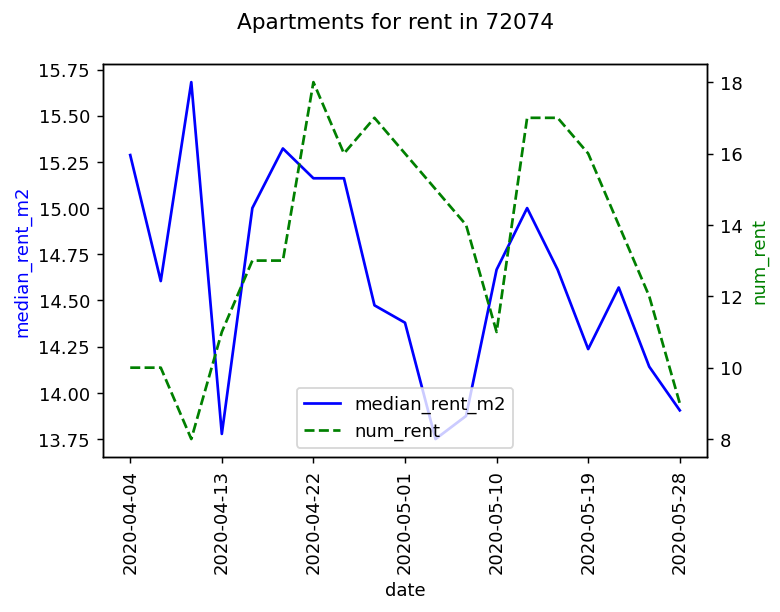

<IPython.core.display.Javascript object>

In [114]:
group_attributes = [72074]
feature1 = "median_rent_m2"
feature2 = "num_rent"

for attr in group_attributes:
    plot_2features(time_df, "rent", attr, dates, feature1, feature2)

### 2.3) Apartments for sale

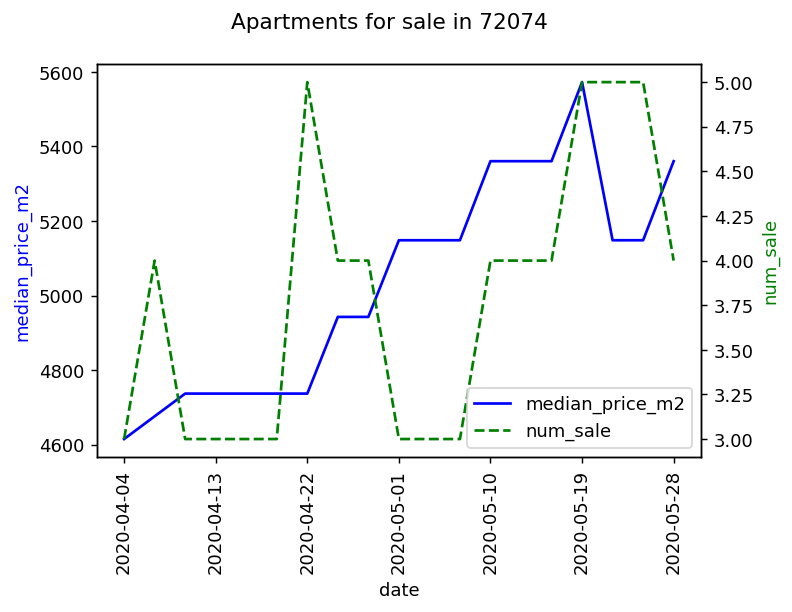

<IPython.core.display.Javascript object>

In [115]:
group_attributes = [72074]
feature1 = "median_price_m2"
feature2 = "num_sale"

for attr in group_attributes:
    plot_2features(time_df, "sale", attr, dates, feature1, feature2)

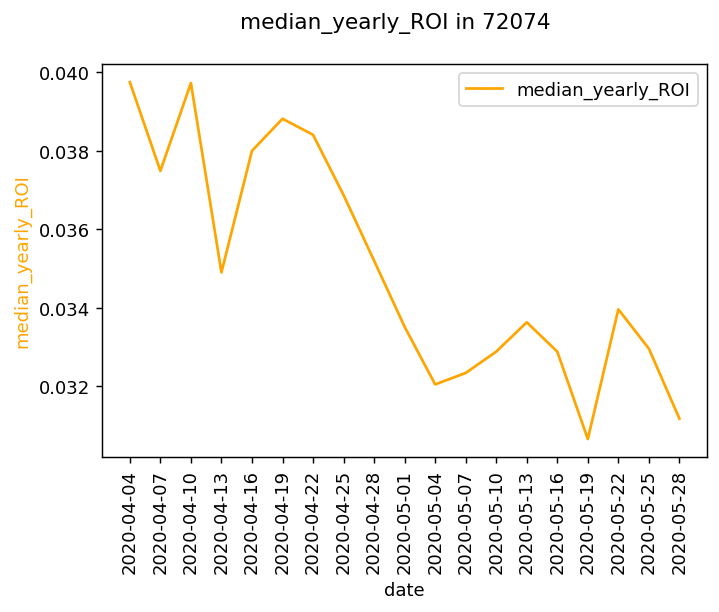

<IPython.core.display.Javascript object>

In [116]:
group_attributes = [72074]
feature1 = "median_yearly_ROI"

for attr in group_attributes:
    plot_1feature(time_df, attr, dates, feature1)